In [1]:
# Analysis script written by Sigfrid Stjärnholm with code from Stephen McAleer
# 22 april 2022 (old 5th february 2022)

# Imports
import numpy as np

# Load data
dataset_names = ["simple_noise", "simple_nonoise", "simple2_nonoise"]
# BASE_PATH = "/mnt/ssd2/data/SouthPole/single_surface_4LPDA_PA_15m_RNOG_fullsim.json/Alvarez2009_had_noise.yaml/G03generate_events_full_surface_sim/post/LPDA_2of4_100Hz/1dipole_noiseless" # Christians path
BASE_PATH = "/mnt/md0/data/SouthPole/single_surface_4LPDA_PA_15m_RNOG_fullsim.json/Alvarez2009_had_noise.yaml/G03generate_events_full_surface_sim/LPDA_2of4_100Hz/4LPDA_1dipole_fullband" # The path i found that matched 
norm = 1e-6

x_list = []
y_list = []

for dataset_name in dataset_names:
    print(f"Loading {dataset_name}: ", end="")
    for i in range(28):
        new_data = np.load(f"{BASE_PATH}/data_{dataset_name}_000001_LPDA_2of4_100Hz_4LPDA_1dipole_fullband_{i:04d}.npy")
        new_labels = np.load(f"{BASE_PATH}/labels_000001_LPDA_2of4_100Hz_4LPDA_1dipole_fullband_{i:04d}.npy", allow_pickle=True)
        print(".", end="")

        if i==0:
            data = new_data
            labels = new_labels

            shower_energy_had = np.array(labels.item()["shower_energy_had"])
            shower_energy_had = np.log10(shower_energy_had + 1)
            shower_energy_had = shower_energy_had.reshape(shower_energy_had.shape[0], 1)

            idx = ~(np.isnan(data))
            idx = np.all(idx, axis=1)
            data = data[idx, :]
            shower_energy_had = shower_energy_had[idx]
            data = data/norm
            x = data
            y = shower_energy_had
            
        else:
            data = new_data
            labels = new_labels

            shower_energy_had = np.array(labels.item()["shower_energy_had"])
            shower_energy_had = np.log10(shower_energy_had + 1)
            shower_energy_had = shower_energy_had.reshape(shower_energy_had.shape[0], 1)

            idx = ~(np.isnan(data))
            idx = np.all(idx, axis=1)
            data = data[idx, :]
            shower_energy_had = shower_energy_had[idx]
            data = data/norm
            x = np.vstack((x, data))
            y = np.vstack((y, shower_energy_had))

    x = np.log10(x+1)
    for i in range(x.shape[1]):
        big_min = np.min(x[:,i])
        big_max = np.max(x[:,i])
        x[:,i] -= big_min
        x[:,i] /= (big_max - big_min)

    # This code was commented out from Stephen
    # big_min = np.min(x[:,10:])
    # big_max = np.max(x[:,10:])
    # x[:,10:] -= big_min
    # x[:,10:] /= (big_max - big_min)
    # lil_min = np.min(x[:,:10])
    # lil_max = np.max(x[:,:10])
    # x[:,:10] -= lil_min
    # x[:,:10] /= (lil_max - lil_min)
    print("\nFinished loading:")
    print("\tx.shape: ", x.shape)
    print("\ty.shape: ", y.shape)

    x_list.append(x)
    y_list.append(y)

Loading simple_noise: ............................
Finished loading:
	x.shape:  (2799952, 10)
	y.shape:  (2799952, 1)
Loading simple_nonoise: ............................
Finished loading:
	x.shape:  (2799952, 10)
	y.shape:  (2799952, 1)
Loading simple2_nonoise: ............................
Finished loading:
	x.shape:  (2799952, 20)
	y.shape:  (2799952, 1)


In [2]:
# Define test data and the model and run predictions
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv1D, Flatten, Dropout
import tensorflow as tf
from keras.utils import np_utils
import matplotlib
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, AveragePooling1D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

Y_test_list = []
Y_pred_list = []

for i, dataset_name in enumerate(dataset_names):
    print(f"Defining model and predicting {dataset_name}")

    x = x_list[i]
    y = y_list[i]

    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.1, shuffle=True)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15, shuffle=True) 
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    # Full model 
    if dataset_name in ["simple_noise", "simple_nonoise"]:
        input_length = 10
    else:
        input_length = 20

    model = Sequential()
    model.add(Conv1D(40, 3, strides=1, padding='valid', activation='relu', input_shape=(input_length,1)))
    model.add(Conv1D(40, 3, strides=1, padding='valid', activation='relu'))

    model.add(Conv1D(60, 3, strides=1, padding='valid', activation='relu'))

    # model.add(Conv1D(80, 3, strides=1, padding='valid', activation='relu', input_shape=(512, 5)))

    # model.add(Conv1D(5, 3, strides=1, padding='valid', activation='relu', input_shape=(512, 5)))
    # model.add(Conv1D(5, 3, strides=1, padding='valid', activation='relu', input_shape=(512, 5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    # model.add(Conv1D(5, 20, strides=1, padding='valid', activation='relu', input_shape=(512,5)))
    model.add(Flatten())
    # model.add(Dense(5 * 512))
    # model.add(Activation('relu'))
    # model.add(Dense(5 * 512))
    # model.add(Activation('relu'))
    # model.add(Dense(4 * 512))
    # model.add(Activation('relu'))
    # model.add(Dense(1024))
    # model.add(Dropout(.2))
    # model.add(Activation('relu'))
    model.add(Dense(256))
    model.add(Dropout(.1))
    model.add(Activation('relu'))
    model.add(Dense(128))
    model.add(Dropout(.1))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',
    #               optimizer=Adam(lr=.0001))
                optimizer=Adam())
    # model.summary()

    ck = f'./{dataset_name}full_model_nov_26.hdf5'
    model.load_weights(ck)

    Y_pred = model.predict(X_test) # The predicted labels
    Y_test = Y_test # The true labels

    Y_test_list.append(Y_test)
    Y_pred_list.append(Y_pred)

    print(f"\tDone predicting {dataset_name}!")

Defining model and predicting simple_noise
	Done predicting simple_noise!
Defining model and predicting simple_nonoise
	Done predicting simple_nonoise!
Defining model and predicting simple2_nonoise
	Done predicting simple2_nonoise!


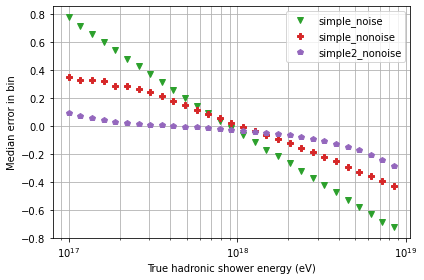

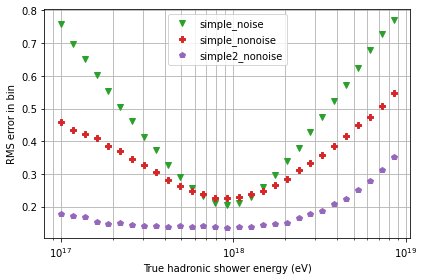

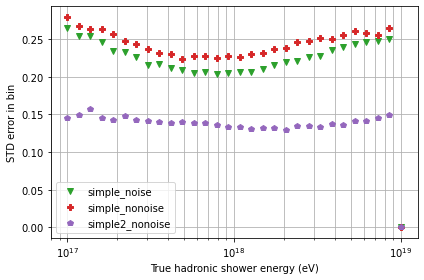

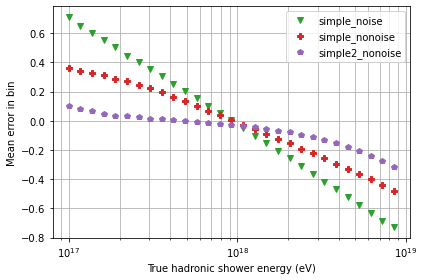

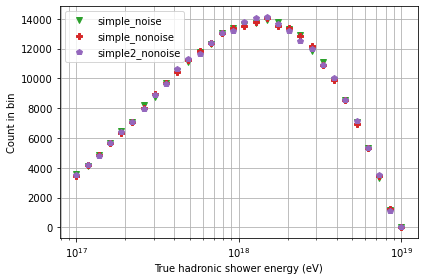

In [3]:
from scipy import stats

# Binning and plotting
colours = ["tab:green", "tab:red", "tab:purple"]
point_format = ["v", "P", "p"]


def calculate_rms(data_to_calcualte):
    return np.sqrt(np.mean(data_to_calcualte**2))

for statistic, statistic_string in zip(["median", calculate_rms, "std", "mean", "count"], ["Median error", "RMS error", "STD error", "Mean error", "Count"]):
    # --------- Energy plotting ---------
    # Create figure
    fig_energy = plt.figure()
    ax = fig_energy.add_subplot(1, 1, 1)

    binned_resolution_nu_energy_list = []
    for i, dataset_name in enumerate(dataset_names):

        # Remove extra dimension of array (it comes from the model)
        Y_test = np.squeeze(Y_test_list[i])
        Y_pred = np.squeeze(Y_pred_list[i])

        energy_difference_data = Y_pred - Y_test

        # Calculate binned statistics
        nu_energy_bins = np.logspace(np.log10(1e17),np.log10(10**19), 30)
        nu_energy_bins_with_one_extra = np.append(np.logspace(np.log10(1e17),np.log10(10**19), 30), [1e20])
        binned_resolution_nu_energy = stats.binned_statistic(10**Y_test, energy_difference_data, bins = nu_energy_bins_with_one_extra, statistic=statistic)[0]

        binned_resolution_nu_energy_list.append(binned_resolution_nu_energy)

        ax.plot(nu_energy_bins, binned_resolution_nu_energy_list[i], point_format[i], label=dataset_name, color = colours[i])
    # ax.set_ylim(0, 0.4)
    ax.set_xlabel(r"True hadronic shower energy (eV)")
    ax.set_ylabel(f"{statistic_string} in bin")
    ax.set_xscale('log')
    ax.legend()

        # ax = fig_energy.add_subplot(1, 2, 2)
        # ax.plot(nu_energy, energy_difference_data, 'o')
        # ax.set_xscale('log')

    plt.grid(True, which="both")
    # plt.title(fr"{statistic_string} as a function of true hadronic shower energy")
    
    fig_energy.tight_layout()
    fig_energy.savefig(f"plots/{statistic_string}_resolution_nu_energy.png", dpi=300)
    # ___________________________________

0.22204213938411668


<ipython-input-8-0d264caa80a0>:114: RuntimeWarning: invalid value encountered in true_divide
  H_norm_rows = Hmasked / np.outer(Hmasked.sum(axis=1, keepdims=True), np.ones(H.shape[1]))


0.23151750972762647
0.5104305826739287


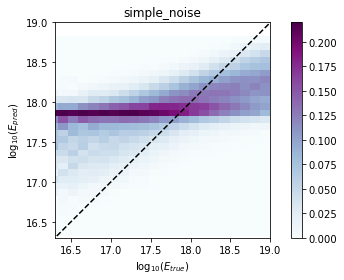

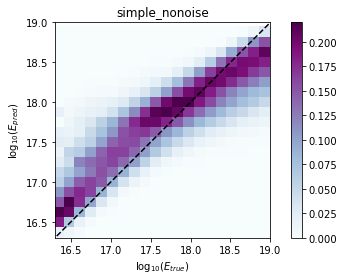

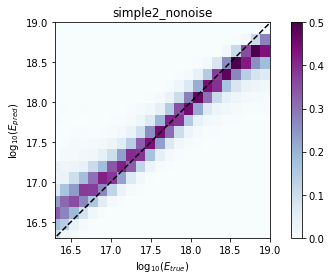

In [8]:
# Create scatter plots
import sys
import matplotlib as mpl

# def get_histogram2d(x=None, y=None, z=None,
#                 bins=10, range=None,
#                 xscale="linear", yscale="linear", cscale="linear",
#                 normed=False, cmap=None, clim=(None, None),
#                 ax1=None, grid=True, shading='flat', colorbar={},
#                 cbi_kwargs={'orientation': 'vertical'},
#                 xlabel="", ylabel="", clabel="", title="",
#                 fname="hist2d.png"):
#     """
#     creates a 2d histogram
#     Parameters
#     ----------
#     x, y, z :
#         x and y coordinaten for z value, if z is None the 2d histogram of x and z is calculated
#     numpy.histogram2d parameters:
#         range : array_like, shape(2,2), optional
#         bins : int or array_like or [int, int] or [array, array], optional
#     ax1: mplt.axes
#         if None (default) a olt.figure is created and histogram is stored
#         if axis is give, the axis and a pcolormesh object is returned
#     colorbar : dict
#     plt.pcolormesh parameters:
#         clim=(vmin, vmax) : scalar, optional, default: clim=(None, None)
#         shading : {'flat', 'gouraud'}, optional
#     normed: string
#         colum, row, colum1, row1 (default: None)
#     {x,y,c}scale: string
#         'linear', 'log' (default: 'linear')
#     """

#     if z is None and (x is None or y is None):
#         sys.exit("z and (x or y) are all None")

#     if ax1 is None:
#         fig, ax = plt.subplots(1)
#         fig.subplots_adjust(wspace=0.3, left=0.05, right=0.95)
#     else:
#         ax = ax1

#     if z is None:
#         z, xedges, yedges = np.histogram2d(x, y, bins=bins, range=range)
#         z = z.T
#     else:
#         xedges, yedges = x, y

#     if normed:
#         if normed == "colum":
#             z = z / np.sum(z, axis=0)
#         elif normed == "row":
#             z = z / np.sum(z, axis=1)[:, None]
#         elif normed == "colum1":
#             z = z / np.amax(z, axis=0)
#         elif normed == "row1":
#             z = z / np.amax(z, axis=1)[:, None]
#         else:
#             sys.exit("Normalisation %s is not known.")

#     color_norm = mpl.colors.LogNorm() if cscale == "log" else None
#     vmin, vmax = clim
#     im = ax.pcolormesh(xedges, yedges, z, shading=shading, vmin=vmin, vmax=vmax, norm=color_norm, cmap=cmap)

#     if colorbar is not None:
#         cbi = plt.colorbar(im, **cbi_kwargs)
#         cbi.ax.tick_params(axis='both', **{"labelsize": 14})
#         cbi.set_label(clabel)

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)

#     ax.set_xscale(xscale)
#     ax.set_yscale(yscale)

#     ax.set_title(title)

#     return fig, ax, im

def get_2dhist_normalized_columns(X, Y, fig, ax, binsx, binsy, shading='flat', clim=(None, None), norm=None, cmap=None):
    """
    creates a 2d histogram where the number of entries are normalized to 1 per column
    Parameters
    ----------
    X: array
        x values
    Y: array
        y values
    fig: figure instance
        the figure to plot in
    ax: axis instance
        the axis to plot in
    binsx: array
        the x bins
    binsy: array
        the y bins
    shading: string
        fill style {'flat', 'gouraud'}, see matplotlib documentation (default flat)
    clim: tuple, list
        limits for the color axis (default (None, None))
    norm: None or Normalize instance (e.g. matplotlib.colors.LogNorm()) (default None)
        normalization of the color scale
    cmap: string or None
        the name of the colormap
    Returns
    --------
    pcolormesh object, colorbar object
    """
    H, xedges, yedges = np.histogram2d(X, Y, bins=[binsx, binsy])
    np.nan_to_num(H)
    # Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
    Hmasked = H
    H_norm_rows = Hmasked / np.outer(Hmasked.sum(axis=1, keepdims=True), np.ones(H.shape[1]))

    # ax.set_xlim(16.3, 19)
    # ax.set_ylim(16.3, 19)

    # if run_id == "E13.1":
    #     ax.set_xlim(17, 19)
    #     ax.set_ylim(17, 19)

    max_value_in_range = 0
    for i, x in enumerate(xedges[:-1]):
        for j, y in enumerate(yedges[:-1]):
            if 16.3 < x < 19 and 16.3 < y < 19:
                if H_norm_rows[i, j] > max_value_in_range:
                    max_value_in_range = H_norm_rows[i, j]

    print(max_value_in_range)

    if(cmap is not None):
        cmap = plt.get_cmap(cmap)

    vmin, vmax = clim
    pc = ax.pcolormesh(xedges, yedges, H_norm_rows.T, shading=shading, vmin=vmin, vmax=vmax , norm=norm, cmap=cmap)
    cb = fig.colorbar(pc, ax=ax, orientation='vertical')

    return pc, cb

for i, dataset_name in enumerate(dataset_names):

    # Remove extra dimension of array (it comes from the model)
    Y_test = np.squeeze(Y_test_list[i])
    Y_pred = np.squeeze(Y_pred_list[i])

    energy_difference_data = Y_pred - Y_test

    # Constants
    cmap = "BuPu"
    log_E_string = r"$\log_{10}\:E$"
    xlabel = r"$\log_{10}(E_{true})$"
    ylabel = r"$\log_{10}(E_{pred})$"
    bins = 30
    clim = [0, 0.22]

    if dataset_name == "simple2_nonoise":
        clim = [0, 0.5]

    # plot_title = f"Heatmap of predicted and true shower energies\nfor dataset {dataset_name}"
    plot_title = dataset_name

    # for cscale in ["linear", "log"]:
    for cscale in ["linear"]:
        # Also plot a heatmap of the scatter plot instead of just dots
        fig = plt.figure()
        ax = plt.gca()

        # fig, ax, im = get_histogram2d(Y_pred, Y_test, fname=file_name, title=plot_title, xlabel=xlabel, ylabel=ylabel, bins=bins, cmap=cmap, cscale=cscale)
        get_2dhist_normalized_columns(X=Y_test, Y=Y_pred, fig=fig, ax=ax, cmap=cmap, binsx=bins, binsy=bins, clim=clim)
        ax.set_aspect('equal', 'box')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(plot_title)

        # Plot a black line through the middle
        xmin = min(Y_pred)
        xmax = max(Y_pred)
        ymin = min(Y_test)
        ymax = max(Y_test)

        ax.plot([min(xmin, ymin), max(xmax, ymax)], [min(xmin, ymin), max(xmax, ymax)], 'k--')

        ax.set_xlim(16.3, 19)
        ax.set_ylim(16.3, 19)

        plt.tight_layout()
        plt.savefig(f"plots/scatter_2dhistogram_{dataset_name}_cscale{cscale}_SQUAREASPECT_NORMALIZED.png", dpi=300)
        plt.savefig(f"plots/scatter_2dhistogram_{dataset_name}_cscale{cscale}_SQUAREASPECT_NORMALIZED.eps", format="eps")

In [ ]:
### Generate energy resolution histogram
from radiotools import plthelpers as php

for i, dataset_name in enumerate(dataset_names):
    energy_difference_data, shower_energy_log10_predict, shower_energy_log10 = get_pred_energy_diff_data(run_name, True)

    # Redefine N
    N = energy_difference_data.size

    # Calculate 68 %
    energy_68 = calculate_percentage_interval(energy_difference_data, 0.68)

    delta_log_E_string = r"$\log_{10}(E_{pred}) - \log_{10}(E_{true})$"
    plt.rcParams["figure.figsize"] = (4.8,4.8)
    # fig, ax = php.get_histogram(predicted_nu_energy[:, 0], bins=np.arange(17, 20.1, 0.05), xlabel="predicted energy")
    fig, ax = php.get_histogram(energy_difference_data, bins=np.linspace(-1.2, 1.2, 90),
                                xlabel=f"{delta_log_E_string}", ylabel="Events",
                                kwargs={'color':"lightsteelblue", 'ec':"k"})
    # ax.plot(xl, N*stats.rayleigh(scale=scale, loc=loc).pdf(xl))


    plot_title = dataset_name

    plt.title(plot_title)
    plt.tight_layout()
    fig.savefig(f"plots/energy_resolution_{dataset_name}.png", dpi=300)
    fig.savefig(f"plots/energy_resolution_{dataset_name}.eps", format="eps")